I copied the data collection part from this notebook : https://www.kaggle.com/imdevskp/covid-19-analysis-viz-prediction-comparisons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
# importing datasets
full_table = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


### Cleaning Data

In [3]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
# full_table[cases] = full_table[cases].fillna(0)

In [4]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed']]

In [5]:
country = 'New Zealand'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail()

,Confirmed
Date,
2020-07-10,1543
2020-07-11,1544
2020-07-12,1544
2020-07-13,1545
2020-07-14,1547


In [6]:
country = 'France'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail()

,Confirmed
Date,
2020-07-09,207356
2020-07-10,208015
2020-07-11,208015
2020-07-12,208015
2020-07-13,209640


I will use a model from a marketing paper by Emmanuelle Le Nagard and Alexandre Steyer, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected person / innovation adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

paper is available (in French) [here](https://www.jstor.org/stable/40588987)

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available, but adding a lag parameter could be attempted.

In [7]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [8]:

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 0]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

we need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [9]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt

array([1.96603521e+05, 7.11775742e-02, 1.78324953e+02])

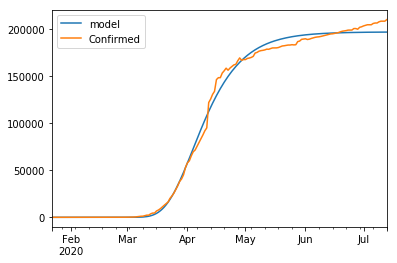

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['model']
pd.concat([model_sim, df], axis=1).plot()
plt.show()

let's extend the prediction curve

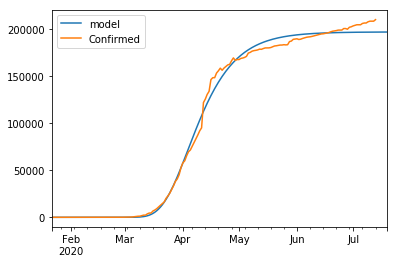

In [11]:
import datetime
start_date = df.index[0]
n_days = 180
extended_model_x = []
for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.concat([extended_model_sim, df], axis=1).plot()
plt.show()

let's display predictions for future weeks

In [12]:
df.tail()

,Confirmed
Date,
2020-07-09,207356
2020-07-10,208015
2020-07-11,208015
2020-07-12,208015
2020-07-13,209640


In [13]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 7 == 0].astype({'model': 'int32'})

,Confirmed,model
2020-01-28,4,0
2020-02-07,6,0
2020-02-14,11,0
2020-02-21,12,0
2020-02-28,57,0
2020-03-07,959,120
2020-03-14,"4,496",2276
2020-03-21,"14,463",13269
2020-03-28,"38,105",38402
2020-04-07,"79,163",88375


now let's compare the dynamic in different countries

In [14]:
def display_fit(df, opt, ax):
    model_x = []
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt, t)])
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['model']
    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

def display_extended_curve(df, opt, ax):
    start_date = df.index[0]
    n_days = 200
    extended_model_x = []
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['model -> ' + str(int(opt[0]))]
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))



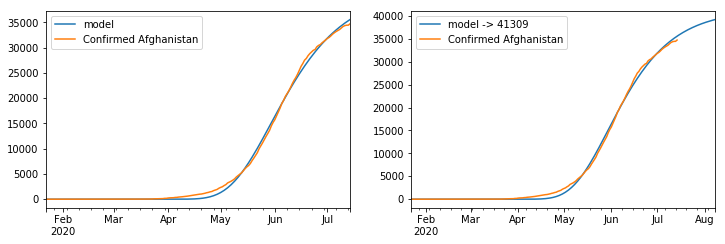

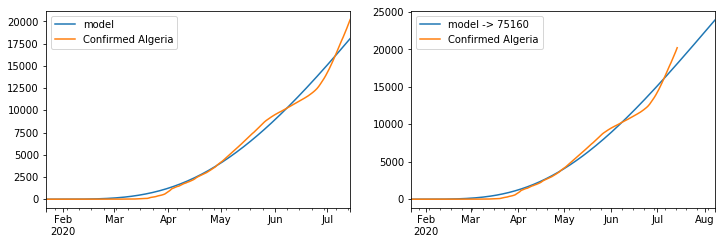

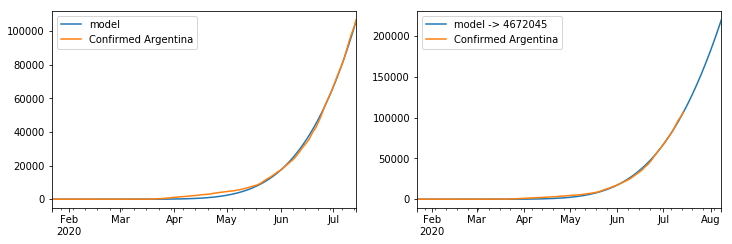

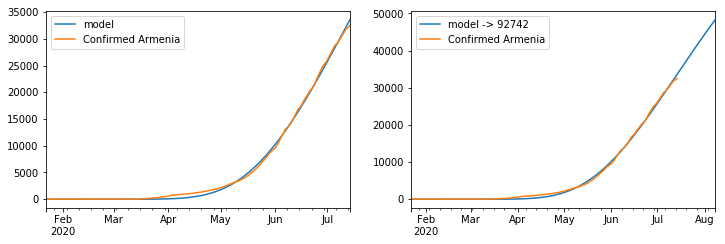

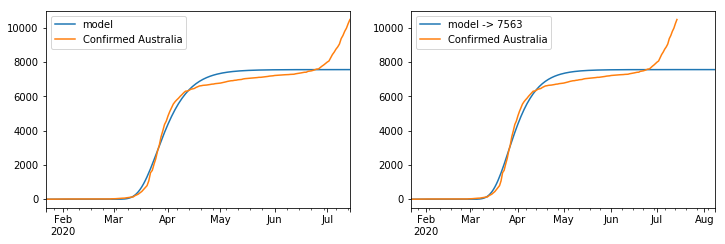

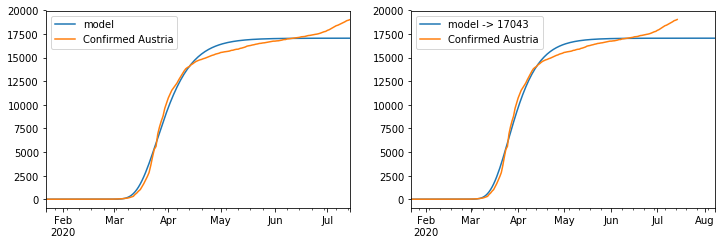

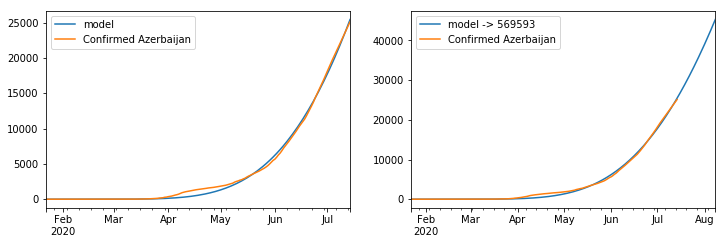

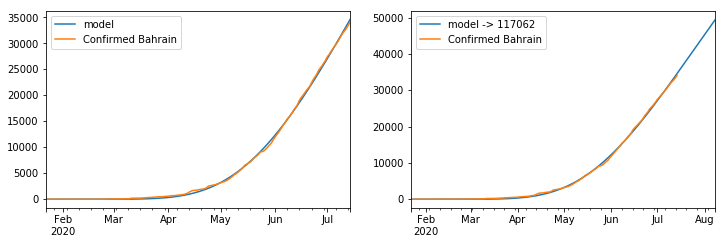

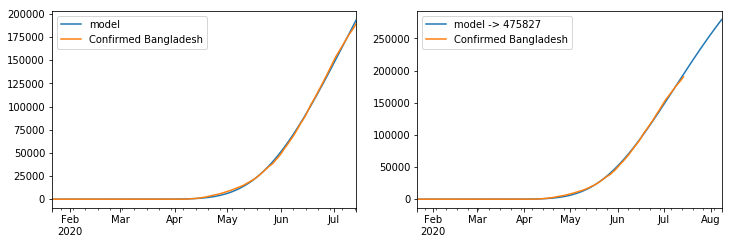

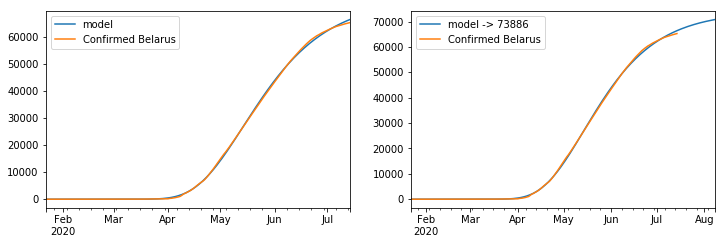

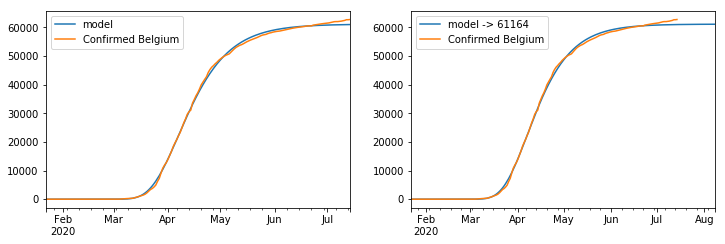

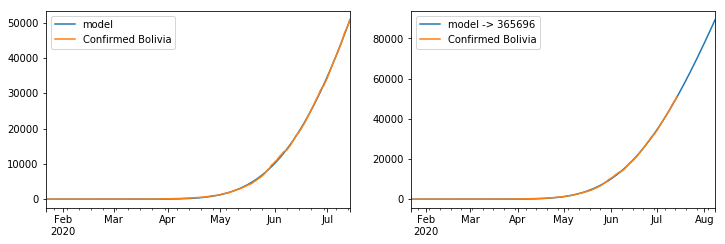

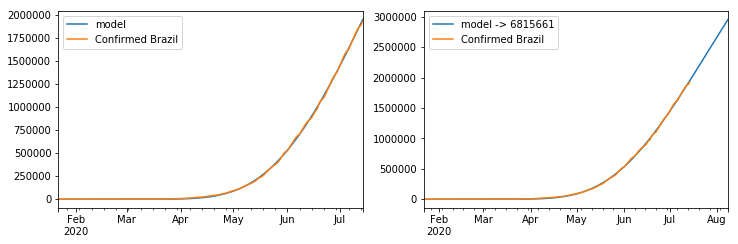

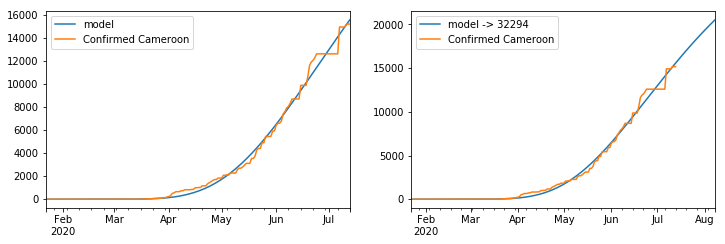

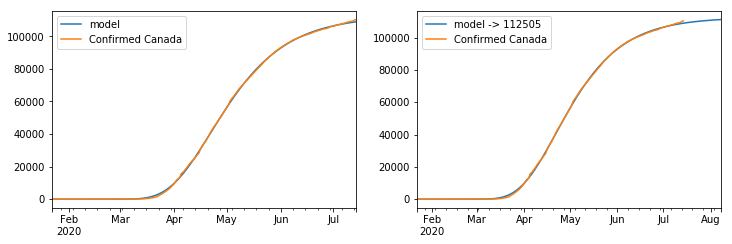

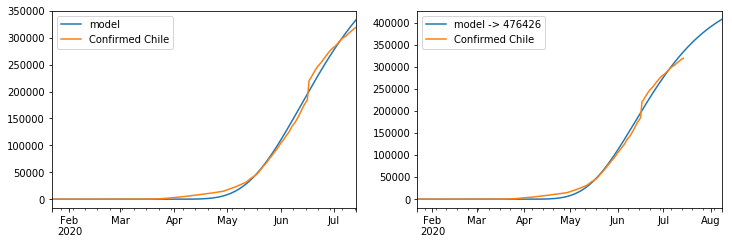

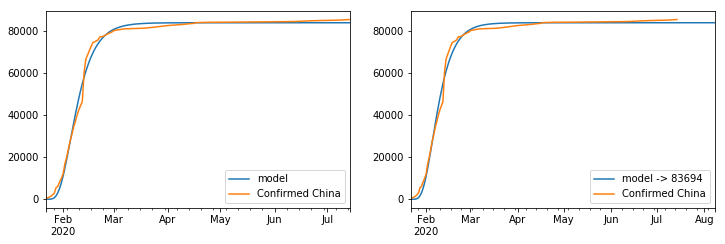

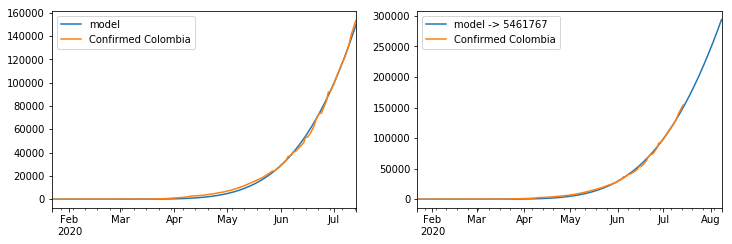

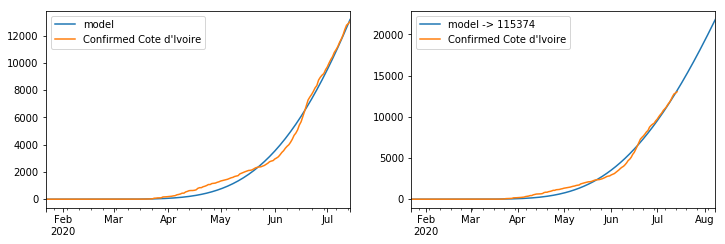

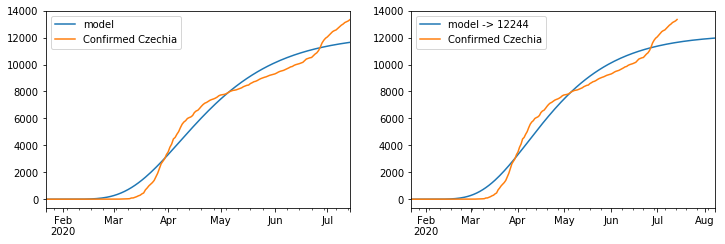

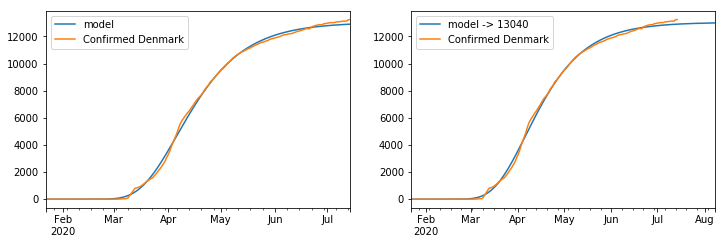

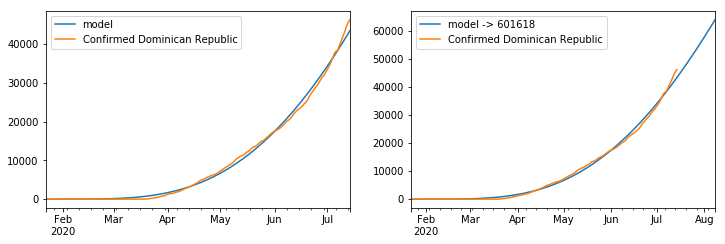

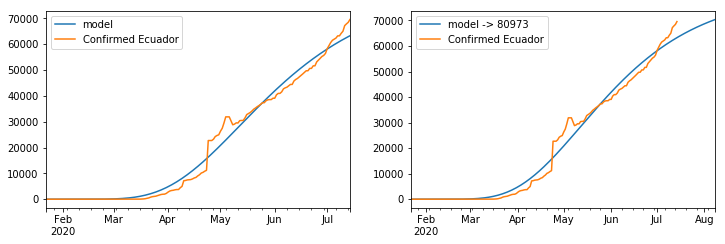

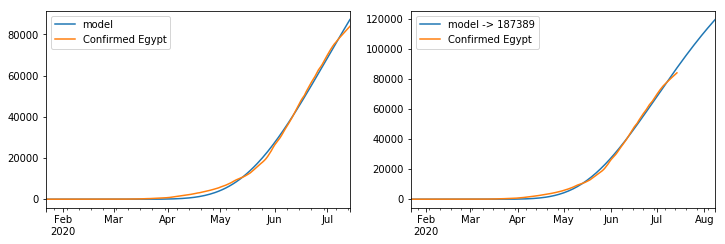

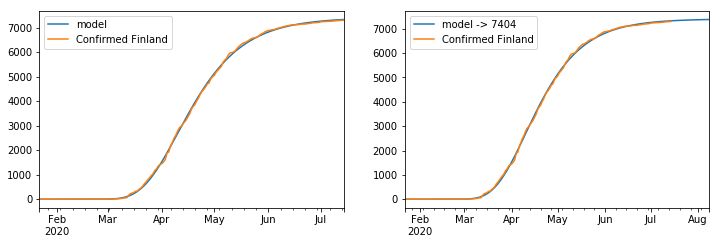

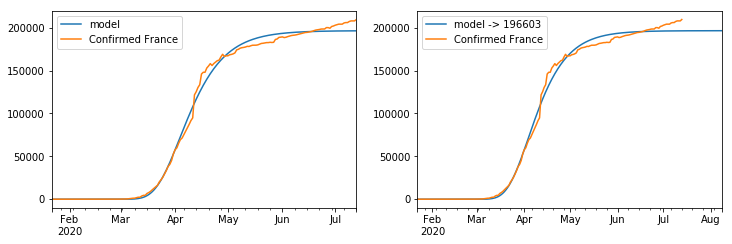

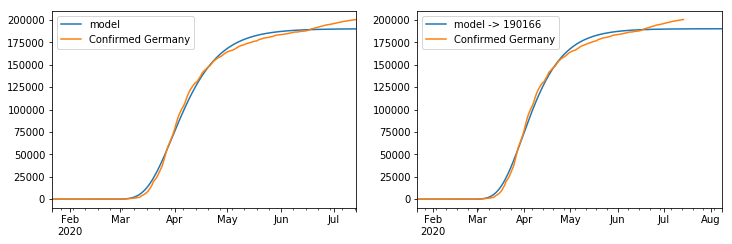

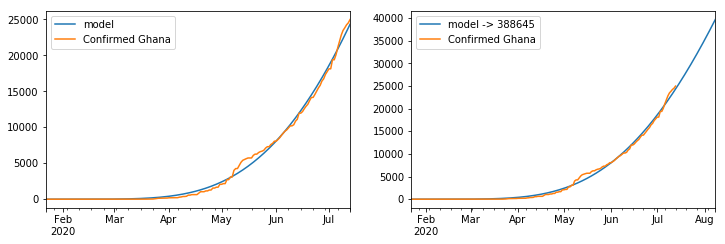

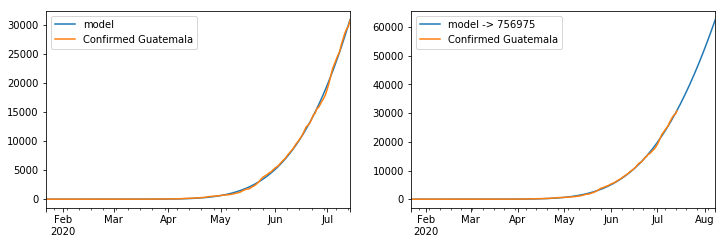

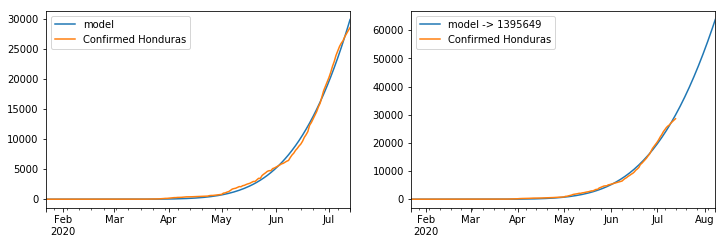

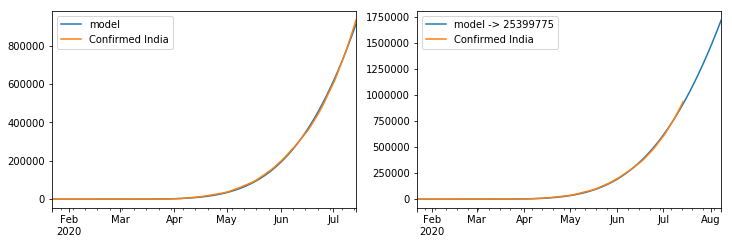

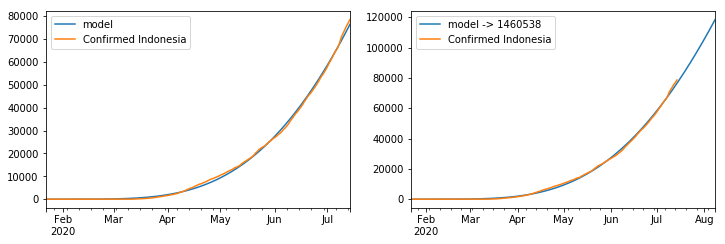

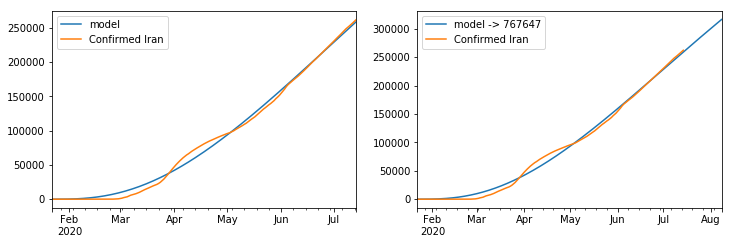

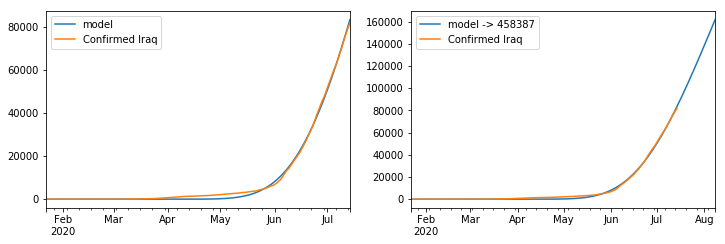

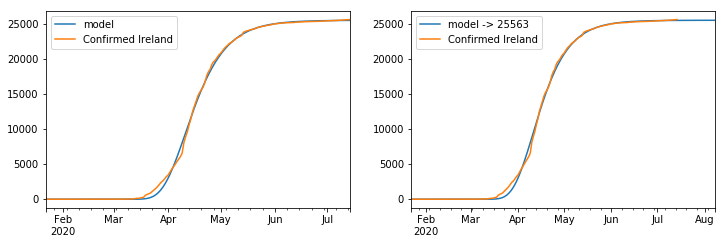

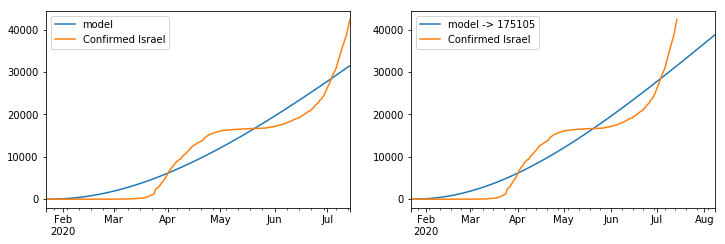

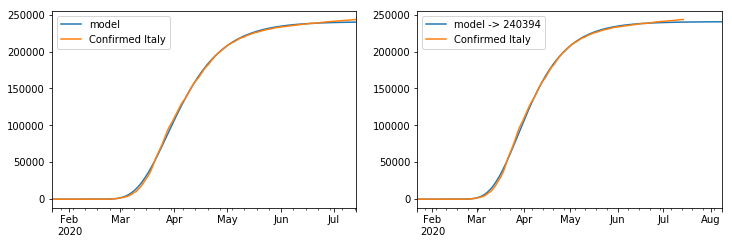

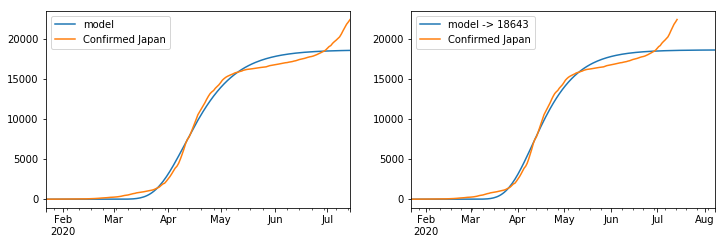

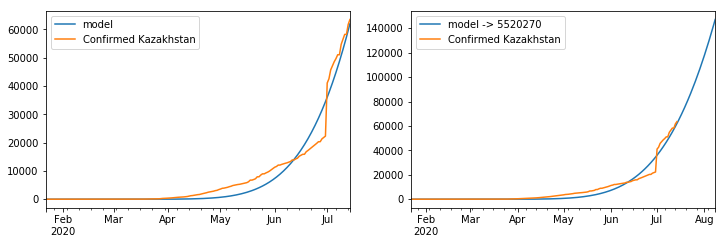

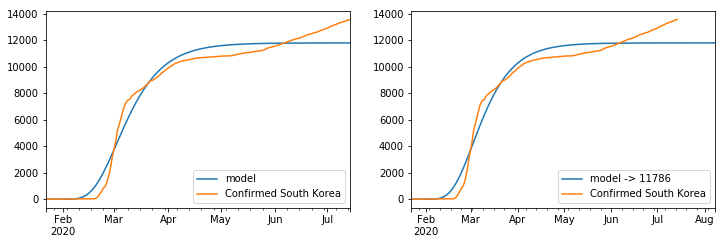

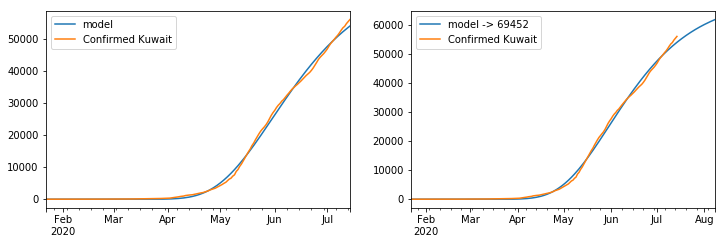

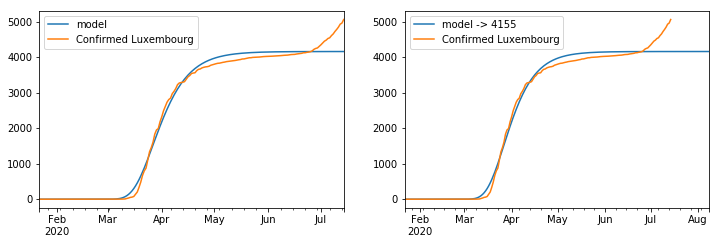

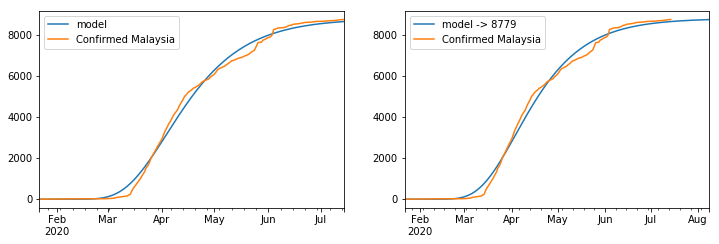

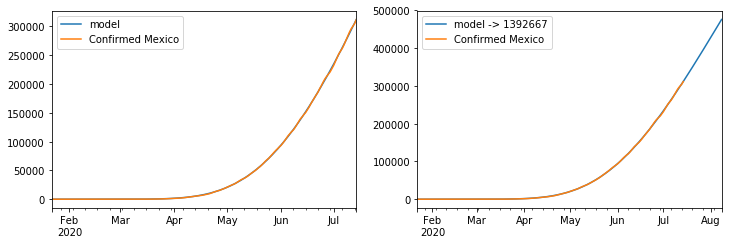

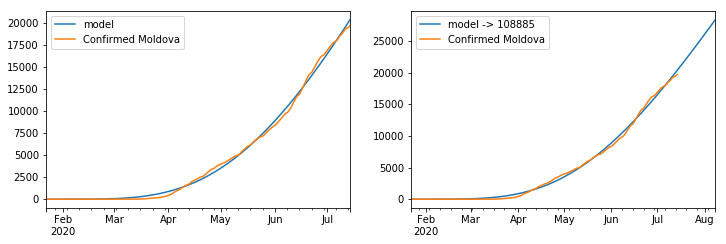

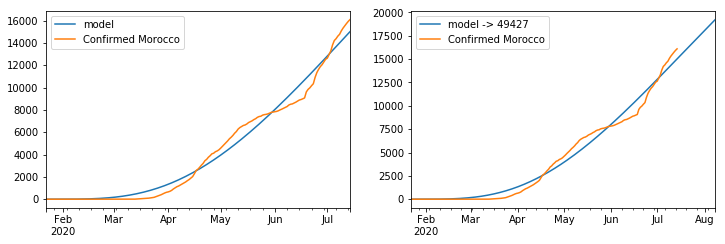

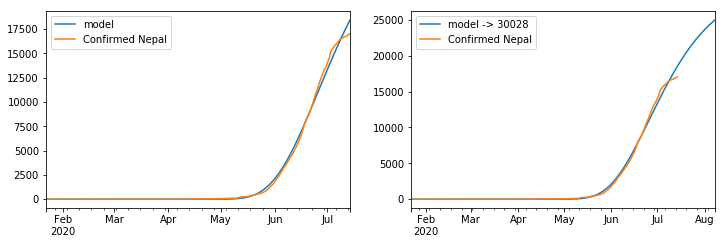

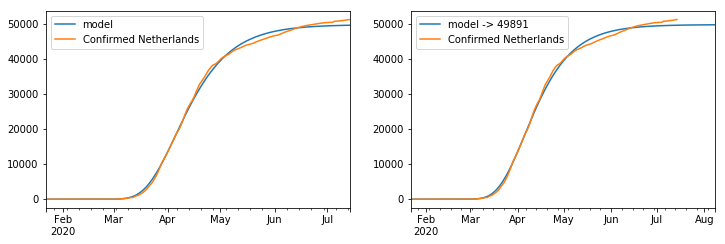

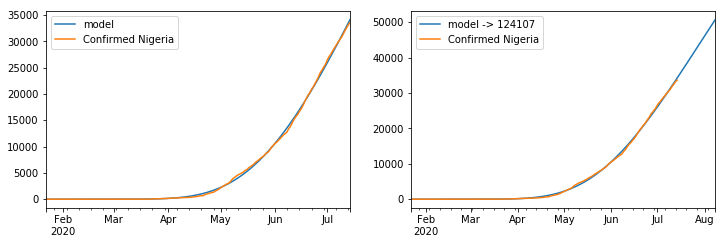

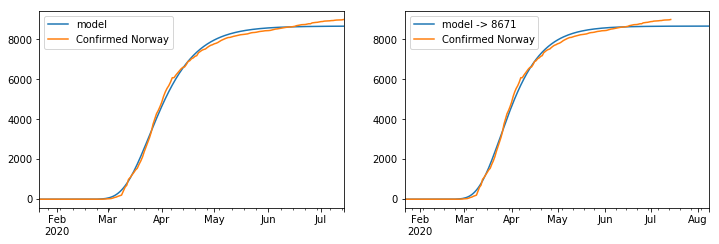

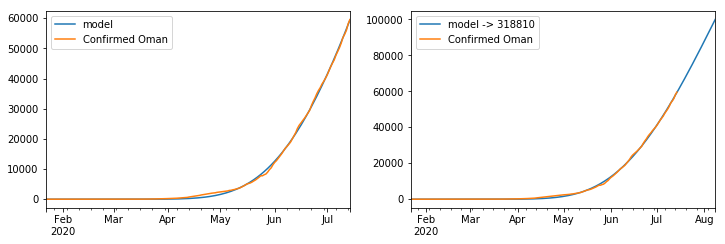

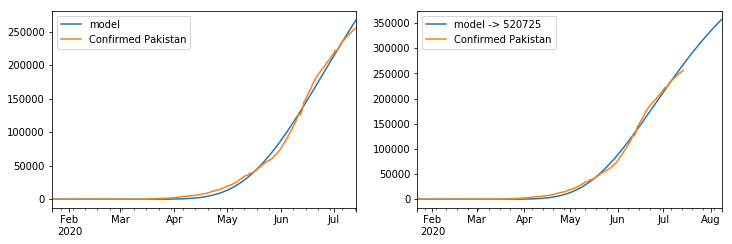

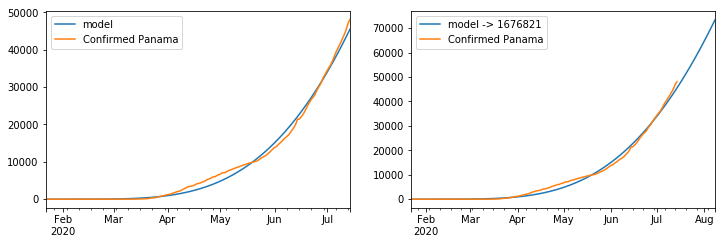

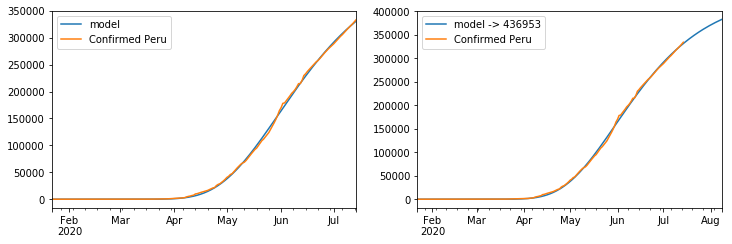

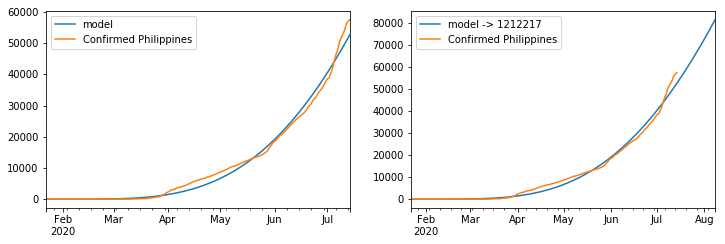

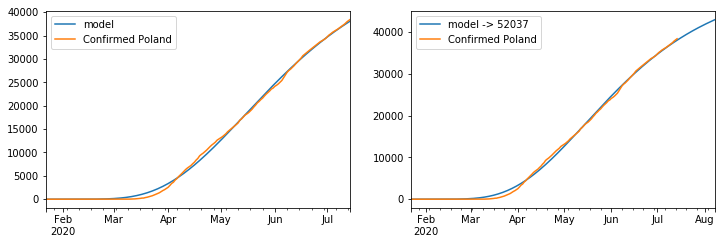

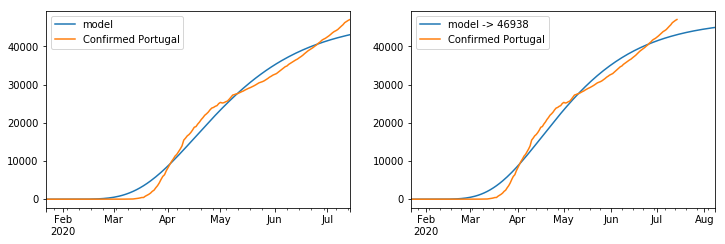

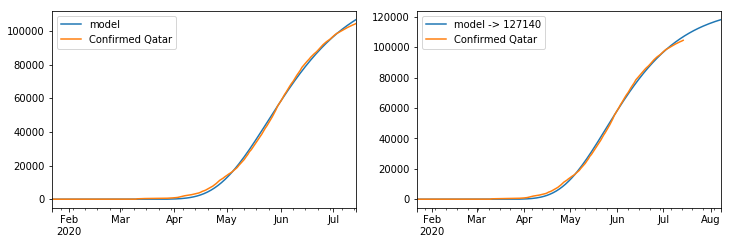

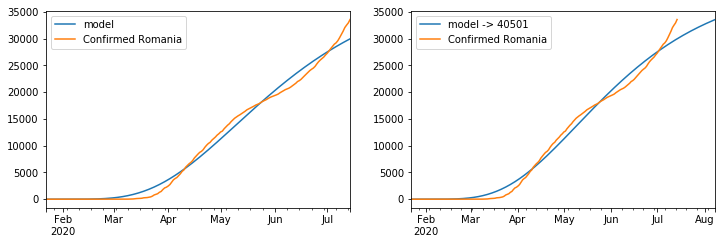

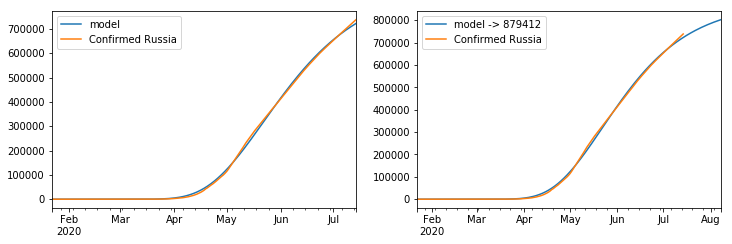

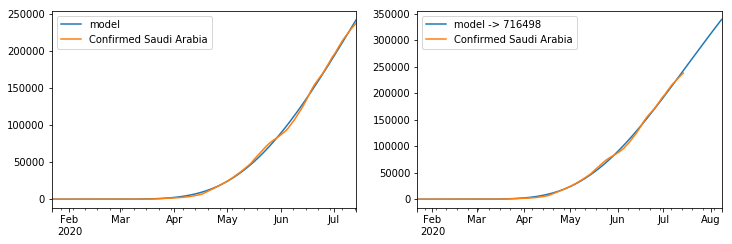

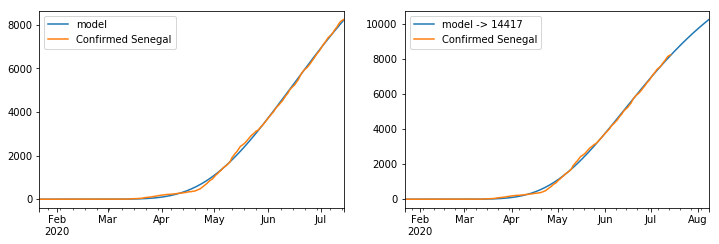

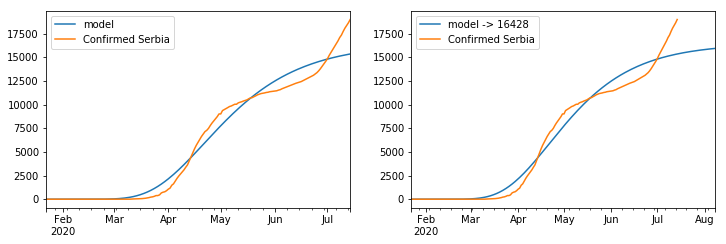

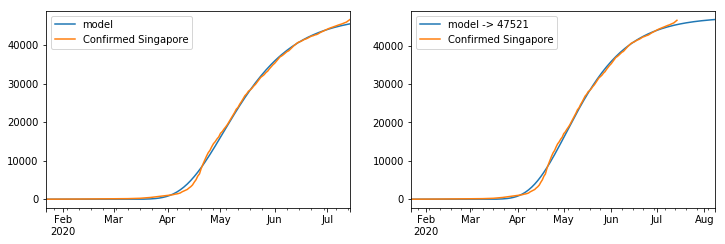

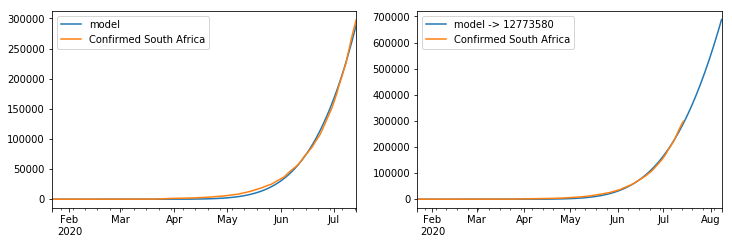

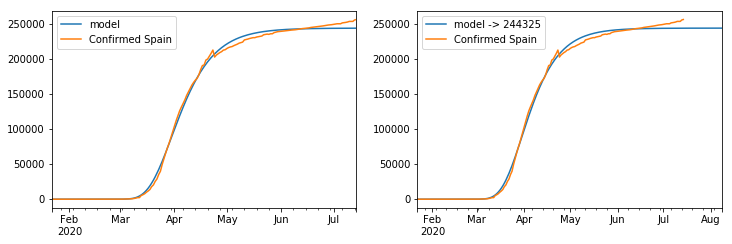

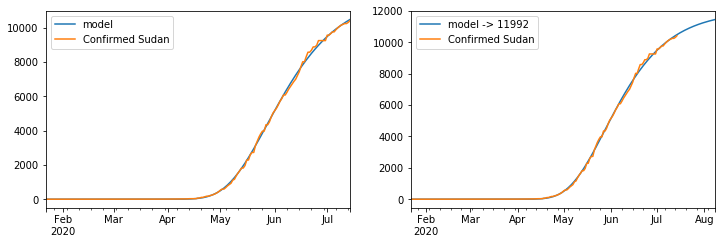

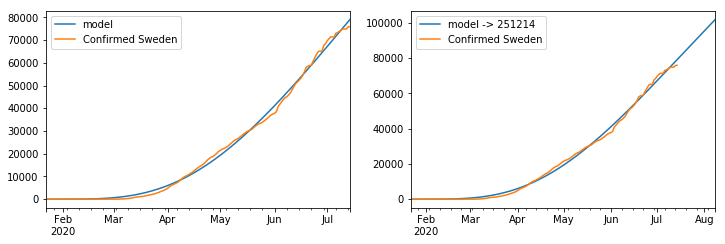

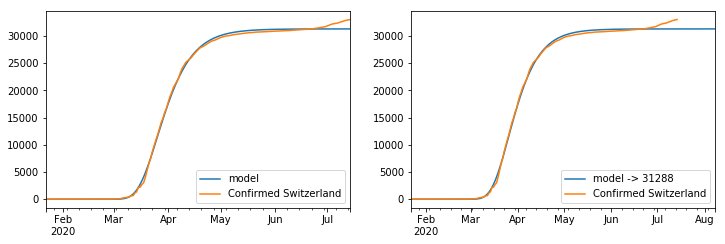

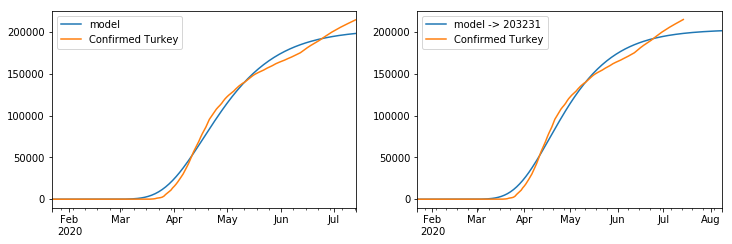

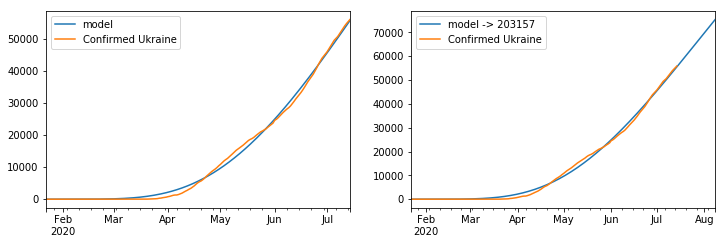

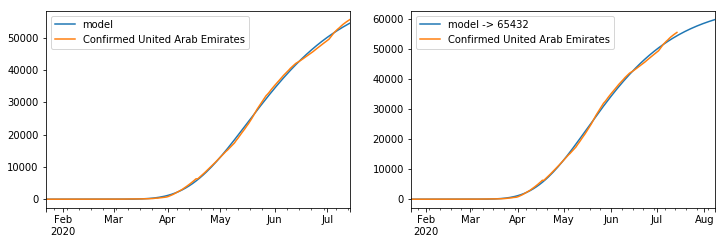

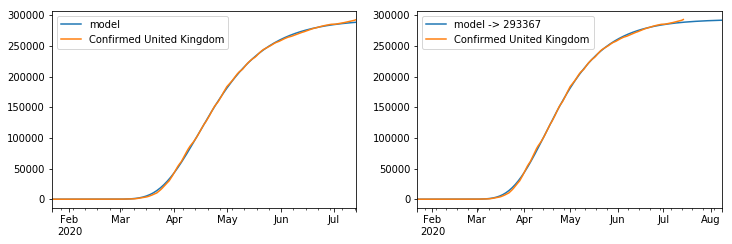

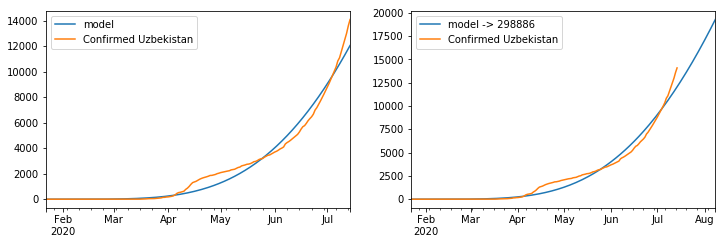

In [15]:
stats = []
for country in full_table['Country/Region'].unique():
# for country in ['Sweden']:
    df = get_time_series(country)
    # only consider countries with at least 5000 cases (plus Sweden)
    if len(df) == 0 or (max(df['Confirmed']) < 5000 and country != 'Sweden'): 
        continue
    df.columns = [df.columns[0] + ' ' + country]
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
#     if country == 'France':
#         display(df.tail())
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
#     print(country, opt)
    if min(opt) > 0:
        stats.append([country, *opt])
        n_plot = len(stats)
        plt.figure(1)
#         ax1 = plt.subplot(221)
#         display_fit(df, opt, ax1)
        ax2 = plt.subplot(221)
        display_extended_curve(df, opt, ax2)
        plt.show()
stats_df = pd.DataFrame(stats)
# stats_df.columns = ['country', 'N', 'a', 'alpha', 'lag']
stats_df.columns = ['country', 'N', 'a', 'alpha']

let's see if we can make some sense from the parameters. The N is the projected total number of cases in a given country

In [16]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'N': 'int'}).sort_values(by='N', ascending=False)

,country,N,a,alpha
30,India,25399775,0.0072,9.9541
64,South Africa,12773580,0.0094,17.4981
12,Brazil,6815661,0.0157,18.7669
38,Kazakhstan,5520270,0.0074,13.7924
17,Colombia,5461767,0.0070,10.2841
2,Argentina,4672045,0.0074,11.7081
52,Panama,1676821,0.0041,5.3799
31,Indonesia,1460538,0.0049,5.3562
29,Honduras,1395649,0.0072,11.3916
43,Mexico,1392667,0.0126,12.6544


N is the potential spread in the country if the dynamics since the beginning of the epidemy persist. One problem is that sometimes we're measuring the spread of testing rather than of the epidemy. 

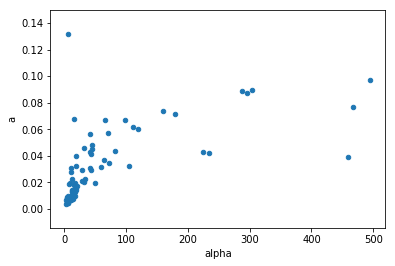

In [17]:
ax = stats_df.plot.scatter(x='alpha', y='a')
# ax.set_xlim([0, 100])
plt.show()